**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.neighbors import KDTree
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer


from scipy import spatial

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        
    def fit(self, X, y):
        if self.algorithm == 'brute':
            if (type(X) != np.ndarray):
                self.x_train = X.toarray()
            else:
                self.x_train = X
            self.x_train = (self.x_train - np.mean(self.x_train, axis = 0)) / np.std(self.x_train, axis = 0)
            
        elif self.algorithm == 'kd_tree':
            if (type(X) != np.ndarray):
                self.x_train_tree = X.toarray()
            else:
                self.x_train_tree = X
            self.x_train_tree = KDTree((X - np.mean(X, axis = 0)) / np.std(X, axis = 0))
        self.y_train = y
        
    def predict(self, X):
        if (type(X) != np.ndarray):
            self.x_test = X.toarray()
        else:
            self.x_test = X
        self.x_test = (self.x_test - np.mean(self.x_test, axis = 0)) / np.std(self.x_test, axis = 0)
        
        if self.algorithm == 'brute':
            distant = pairwise_distances(self.x_test, self.x_train, metric = self.metric)
            
            distant =  np.argpartition(distant, self.n_neighbors, axis=1)
            
            priznaki = self.y_train[distant][:, 0:self.n_neighbors]
            
        elif self.algorithm == 'kd_tree':
            
            distant, indices = self.x_train_tree.query(self.x_test, self.n_neighbors)
            
            priznaki = self.y_train[indices]
        
        indices = np.unique(priznaki, return_inverse=True)
        
        return indices[0][np.argmax(np.apply_along_axis(np.bincount, 1, priznaki, None, np.max(indices[1]) + 1), axis=1)]
            

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, 'Score must be equal'

In [8]:
counter_better = 0
counter_equal = 0
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
    my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    
    if accuracy_score(y_test, my_clf_pred) >  accuracy_score(y_test, sklearn_pred ):
        counter_better += 1
    elif accuracy_score(y_test, my_clf_pred) == accuracy_score(y_test, sklearn_pred ):
        counter_equal += 1
print(counter_better, 'better', counter_equal, 'equal')

200 better 581 equal


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 508 µs, sys: 126 µs, total: 634 µs
Wall time: 564 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 369 µs, sys: 183 µs, total: 552 µs
Wall time: 471 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 1.96 ms, sys: 336 µs, total: 2.3 ms
Wall time: 2.2 ms


array([1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 0, 2])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 1.02 ms, sys: 330 µs, total: 1.35 ms
Wall time: 1.09 ms


array([1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 0, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 966 µs, sys: 685 µs, total: 1.65 ms
Wall time: 1.09 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 516 µs, sys: 206 µs, total: 722 µs
Wall time: 605 µs


In [17]:
%time clf.predict(X_test)

CPU times: user 2.07 ms, sys: 318 µs, total: 2.39 ms
Wall time: 2.25 ms


array([0, 2, 0, 2, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 1])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 848 µs, sys: 298 µs, total: 1.15 ms
Wall time: 894 µs


array([0, 2, 0, 2, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 1])

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [20]:
counter_better = 0
counter_equal = 0
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
    my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    if accuracy_score(y_test, my_clf_pred) >  accuracy_score(y_test, sklearn_pred ):
        counter_better += 1
    elif accuracy_score(y_test, my_clf_pred) == accuracy_score(y_test, sklearn_pred ):
        counter_equal += 1
print(counter_better, 'better', counter_equal, 'equal')

206 better 577 equal


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [21]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [22]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [23]:
#data = [re.sub(r'[^0-9a-zA-Z@]+', ' ', text) for text in data]
vectorize = CountVectorizer(data, min_df = 0.005)
vectorizer = TfidfVectorizer(data, min_df = 0.005)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
matrix_tfidf = vectorizer.fit_transform(data)
matrix = vectorize.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [25]:
rkf = KFold(n_splits=3)
test = rkf.split(matrix)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [26]:
def calculate_optimal(X, y, alg='brute', metr='euclidean'):
    scores = np.array(range(19), dtype=float)
    for n in range(1, 20):
        print(n, 'iteration')
        rkf = KFold(n_splits=3, shuffle = True)
        test = rkf.split(X)
        my_clf = MyKNeighborsClassifier(n_neighbors=n+1, algorithm=alg, metric=metr)
        curr_result = []
        for training, testing in test:
            training_X, training_Y = X[training], y[training]
            testing_X, testing_Y = X[testing], y[testing]
            my_clf.fit(training_X, training_Y)
            my_clf_pred = my_clf.predict(testing_X)
            curr_result.append(accuracy_score(testing_Y, my_clf_pred))
            print(accuracy_score(testing_Y, my_clf_pred), ' number of neighbours -', n+1)
        scores[n-1] = np.mean(curr_result)
    return scores

In [32]:
brute_eucl_count = calculate_optimal(matrix, target, alg = 'brute', metr = 'euclidean')
brute_eucl_count

1 iteration
0.2014846235418876  number of neighbours - 2
0.20047732696897375  number of neighbours - 2
0.18721824449748078  number of neighbours - 2
2 iteration
0.19750795334040297  number of neighbours - 3
0.18536197295147175  number of neighbours - 3
0.2012728719172633  number of neighbours - 3
3 iteration
0.2150053022269353  number of neighbours - 4
0.21108459294616813  number of neighbours - 4
0.20074250861840362  number of neighbours - 4
4 iteration
0.2046659597030753  number of neighbours - 5
0.20551577830814108  number of neighbours - 5
0.21241050119331742  number of neighbours - 5
5 iteration
0.20784729586426298  number of neighbours - 6
0.20710686820472024  number of neighbours - 6
0.2047202333598515  number of neighbours - 6
6 iteration
0.2150053022269353  number of neighbours - 7
0.21028904799787854  number of neighbours - 7
0.21161495624502785  number of neighbours - 7
7 iteration
0.21367974549310711  number of neighbours - 8
0.2100238663484487  number of neighbours - 8
0.2

array([0.1963934 , 0.19471427, 0.20894413, 0.20753075, 0.20655813,
       0.2123031 , 0.21292198, 0.20540732, 0.20823691, 0.20903262,
       0.20496571, 0.19984071, 0.20381809, 0.20169602, 0.20275942,
       0.19144451, 0.18728946, 0.19259572, 0.18782034])

In [33]:
brute_cosine_count = calculate_optimal(matrix, target, alg = 'brute', metr = 'cosine')
brute_cosine_count

1 iteration
0.29427359490986216  number of neighbours - 2
0.29249535932113496  number of neighbours - 2
0.29461681251657384  number of neighbours - 2
2 iteration
0.3123011664899258  number of neighbours - 3
0.3068151683903474  number of neighbours - 3
0.30628480509148764  number of neighbours - 3
3 iteration
0.32926829268292684  number of neighbours - 4
0.3163617077698223  number of neighbours - 4
0.3166268894192522  number of neighbours - 4
4 iteration
0.34994697773064687  number of neighbours - 5
0.32564306549986743  number of neighbours - 5
0.3391673296207902  number of neighbours - 5
5 iteration
0.33748674443266174  number of neighbours - 6
0.345266507557677  number of neighbours - 6
0.3362503314770618  number of neighbours - 6
6 iteration
0.35498409331919406  number of neighbours - 7
0.35666931848316097  number of neighbours - 7
0.34765314240254575  number of neighbours - 7
7 iteration
0.35339342523860023  number of neighbours - 8
0.35269159374171305  number of neighbours - 8
0.35

array([0.29379526, 0.30846705, 0.3207523 , 0.33825246, 0.33966786,
       0.35310218, 0.35301393, 0.35893494, 0.35911295, 0.36317803,
       0.36644905, 0.37210546, 0.37599336, 0.37634706, 0.37387322,
       0.37555252, 0.3810328 , 0.3878381 , 0.38032485])

In [29]:
brute_eucl_tfidf = calculate_optimal(matrix_tfidf, target, alg = 'brute', metr = 'euclidean')
brute_eucl_tfidf

1 iteration
0.10286320254506894  number of neighbours - 2
0.09917793688676743  number of neighbours - 2
0.09970830018562715  number of neighbours - 2
2 iteration
0.10233297985153765  number of neighbours - 3
0.10872447626624238  number of neighbours - 3
0.11164147440997083  number of neighbours - 3
3 iteration
0.10418875927889713  number of neighbours - 4
0.1105807478122514  number of neighbours - 4
0.09387430389817025  number of neighbours - 4
4 iteration
0.10153764581124072  number of neighbours - 5
0.10368602492707504  number of neighbours - 5
0.09387430389817025  number of neighbours - 5
5 iteration
0.09968186638388123  number of neighbours - 6
0.09201803235216123  number of neighbours - 6
0.09838239193847785  number of neighbours - 6
6 iteration
0.08854718981972429  number of neighbours - 7
0.09228321400159109  number of neighbours - 7
0.09360912224874039  number of neighbours - 7
7 iteration
0.09544008483563096  number of neighbours - 8
0.09254839565102095  number of neighbours -

array([0.10058315, 0.10756631, 0.10288127, 0.09969932, 0.0966941 ,
       0.09147984, 0.09218638, 0.09298291, 0.0869722 , 0.08096186,
       0.08582306, 0.08105058, 0.08405513, 0.08193417, 0.07892861,
       0.07910608, 0.07512817, 0.07503926, 0.07318339])

In [30]:
new_brute_cosine_tfidf = calculate_optimal(matrix_tfidf, target, alg = 'brute', metr = 'cosine')
new_brute_cosine_tfidf

1 iteration
0.3411983032873807  number of neighbours - 2
0.3556085918854415  number of neighbours - 2
0.3460620525059666  number of neighbours - 2
2 iteration
0.35763520678685046  number of neighbours - 3
0.3664810395120658  number of neighbours - 3
0.36382922301776716  number of neighbours - 3
3 iteration
0.38918345705196183  number of neighbours - 4
0.3879607531158844  number of neighbours - 4
0.38424821002386633  number of neighbours - 4
4 iteration
0.39660657476139977  number of neighbours - 5
0.39618138424821003  number of neighbours - 5
0.4091752850702731  number of neighbours - 5
5 iteration
0.41755037115588545  number of neighbours - 6
0.4099708300185627  number of neighbours - 6
0.4232299124900557  number of neighbours - 6
6 iteration
0.4217921527041357  number of neighbours - 7
0.42216918589233626  number of neighbours - 7
0.4362238133121188  number of neighbours - 7
7 iteration
0.44671261930010603  number of neighbours - 8
0.43728453990983823  number of neighbours - 8
0.4282

array([0.34762298, 0.36264849, 0.38713081, 0.40065441, 0.41691704,
       0.42672838, 0.43742184, 0.43883675, 0.44714465, 0.45545389,
       0.463408  , 0.46402594, 0.46614744, 0.47648882, 0.4817937 ,
       0.48656558, 0.48462075, 0.48665379, 0.48912858])

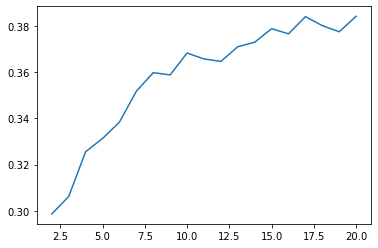

In [31]:
plt.plot(np.arange(2, 21, 1), brute_eucl_count)

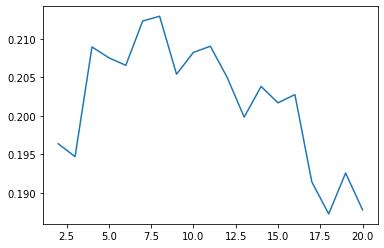

In [35]:
plt.plot(np.arange(2, 21, 1), brute_eucl_count)

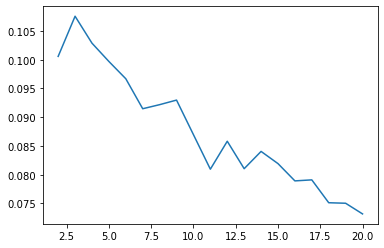

In [36]:
plt.plot(np.arange(2,21,1), brute_eucl_tfidf)

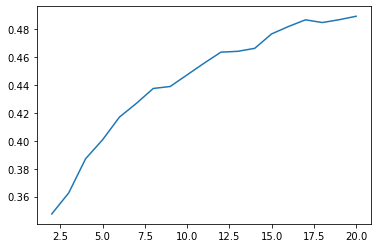

In [37]:
x = np.arange(2, 21, 1)
plt.plot(x, new_brute_cosine_tfidf)

In [31]:
i = np.arange(30,200,10)
scores = np.array(range(len(i)), dtype=float)
k = 0
for n in i:
    print(n, 'iteration')
    rkf = KFold(n_splits=3, shuffle = True)
    test = rkf.split(matrix_tfidf)
    test_clf = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute', metric='cosine')
    curr_result = []
    for training, testing in test:
        training_X, training_Y = matrix_tfidf[training], target[training]
        testing_X, testing_Y = matrix_tfidf[testing], target[testing]
        test_clf.fit(training_X, training_Y)
        test_clf_pred = test_clf.predict(testing_X)
        curr_result.append(accuracy_score(testing_Y, test_clf_pred))
        print(accuracy_score(testing_Y, test_clf_pred), ' number of neighbours -', n)
    scores[k] = np.mean(curr_result)
    k += 1

30 iteration
0.5214740190880169  number of neighbours - 30
0.5165738530893662  number of neighbours - 30
0.5064969504110316  number of neighbours - 30
40 iteration
0.5196182396606575  number of neighbours - 40
0.5269159374171307  number of neighbours - 40
0.5308936621585786  number of neighbours - 40
50 iteration
0.5490455991516436  number of neighbours - 50
0.5330151153540175  number of neighbours - 50
0.5348713869000266  number of neighbours - 50
60 iteration
0.5397667020148462  number of neighbours - 60
0.5558207372049854  number of neighbours - 60
0.5510474675152479  number of neighbours - 60
70 iteration
0.5546129374337222  number of neighbours - 70
0.5518430124635375  number of neighbours - 70
0.5523733757623972  number of neighbours - 70
80 iteration
0.5612407211028632  number of neighbours - 80
0.5523733757623972  number of neighbours - 80
0.5576770087509945  number of neighbours - 80
90 iteration
0.5567338282078473  number of neighbours - 90
0.5672235481304694  number of neigh

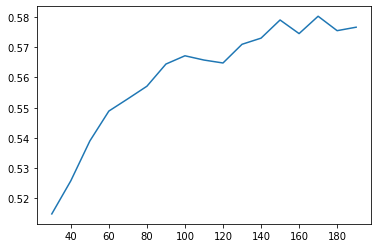

In [32]:
plt.plot(i, scores)

Чем больше соседей - тем значение лучше, возьмем 170.

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [33]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [34]:
new_data = newsgroups_test['data']
new_target = newsgroups_test['target']

In [35]:
vectorizer_test = TfidfVectorizer(new_data, min_df = 0.005)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
matrix_test_tfidf = vectorizer_test.fit_transform(new_data)

In [37]:
rkf = KFold(n_splits=3, shuffle = True)
test = rkf.split(matrix_test_tfidf)
my_clf = MyKNeighborsClassifier(n_neighbors=170, algorithm='brute', metric='cosine')
curr_result = []
for training, testing in test:
    training_X, training_Y = matrix_test_tfidf[training], new_target[training]
    testing_X, testing_Y = matrix_test_tfidf[testing], new_target[testing]
    my_clf.fit(training_X, training_Y)
    my_clf_pred = my_clf.predict(testing_X)
    curr_result.append(accuracy_score(testing_Y, my_clf_pred))
    print(accuracy_score(testing_Y, my_clf_pred), ' number of neighbours -', 110)

0.5507765830346476  number of neighbours - 110
0.5623257666268419  number of neighbours - 110
0.5462151394422311  number of neighbours - 110


Ненамного отличается. Может быть различным, так как разные слова в разных словарях, разная частотность вхождения.